# Deep Face Detection Model 
<strong>by Abdellah Ait Ahmed Ouaal</strong>

## Introduction
<b>In this Deep Face Detection project,</b> we aim to create an advanced system for facial recognition using <b>computer vision and deep learning techniques.</b> We start by carefully setting up our environment and capturing facial images using <b>OpenCV</b> and a webcam. These images are then precisely labeled with <b>Labelme</b> to identify and mark the face. Moving forward, we focus on data preparation, constructing an image loading function, and organizing the dataset for training and testing purposes. To improve the dataset's variety, we use <b>Albumentations</b> for image augmentation. Transitioning to the core of the project, we build and train a <b>deep learning model using the Functional API,</b> define customized loss functions, and optimize for efficient learning. The project concludes with a thorough evaluation of <b>real-time face detection</b> performance.

## 1. Setup and Get Data

>In the first part, we are going to set up the development environment and collect a personalized dataset by utilizing OpenCV and a webcam.<br>
>The annotated images, marked with Labelme, serve as the cornerstone for following parts.
### 1.1 Install Dependencies and Setup

In [ ]:
# Install required packages 
!pip install labelme tensorflow opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [2]:
# Import necessary libraries for setting up and getting data
import os
import time
import uuid
import cv2

In [3]:
# Define the path where the images will be saved and the total number of them 
IMAGES_PATH = os.path.join('data','images')
number_images = 200

In [3]:
# Open a connection to the default camera (camera index 0)
cap = cv2.VideoCapture(0)

# Loop for collecting our 200 images
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    
    # Read a frame from the camera
    ret, frame = cap.read()
    
    # Generate a unique image name using UUID and save the image
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    
    # Display the captured frame and Pause for a short duration
    cv2.imshow('frame', frame)
    time.sleep(1)

    # Check for the 'q' key press to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera resource and close all windows
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [5]:
# Execute the labelme command
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\Abdellah\.labelmerc


## 2. Review Dataset and Build Image Loading Function

> This part of the project focuses on setting up the Data Pipeline, decoding images, and visually inspecting the raw images using Matplotlib.
### 2.1 Import TensorFlow and Dependencies

In [4]:
# Import necessary libraries 
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth
>This part is not required if we use a new version of TensorFlow (if not the installation of tensorflow-gpu is required)


In [ ]:
# Avoid Out-Of-Memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# List all available physical GPUs recognized by TensorFlow
tf.config.list_physical_devices('GPU')

### 2.3 Load Image into TensorFlow Data Pipeline

In [7]:
# Create a TensorFlow Dataset containing file paths of images
# The list_files function is used to list file paths matching a specified pattern
# It specifies all files with the '.jpg' extension in the 'data\\images' directory

images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

In [8]:
# Retrieve the next element from the dataset as a NumPy array
images.as_numpy_iterator().next()

b'data\\images\\7a197bf0-a281-11ee-861a-2cf05d228f6b.jpg'

In [5]:
# This function read and decode a JPEG image file specified by the file path x into a TensorFlow tensor
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [10]:
# Apply the load_image function to each element in the 'images' 
images = images.map(load_image)

In [11]:
# After applying the function for each 'images' element  
images.as_numpy_iterator().next()

array([[[  4,  11,  19],
        [  5,  12,  20],
        [  3,   7,  18],
        ...,
        [ 18,  17,  12],
        [  9,   5,   4],
        [  7,   3,   2]],

       [[  6,  11,  17],
        [  6,  11,  17],
        [  4,   8,  17],
        ...,
        [  9,   8,   4],
        [ 10,   6,   3],
        [ 13,   9,   6]],

       [[ 10,  11,  15],
        [  9,  10,  14],
        [ 15,  16,  21],
        ...,
        [  9,   8,   4],
        [  8,   7,   3],
        [  6,   5,   0]],

       ...,

       [[ 27,  27,  27],
        [ 27,  27,  27],
        [ 27,  27,  27],
        ...,
        [ 28,  30,  29],
        [ 27,  29,  28],
        [ 23,  25,  24]],

       [[246, 246, 246],
        [246, 246, 246],
        [246, 246, 246],
        ...,
        [242, 244, 243],
        [244, 246, 245],
        [242, 244, 243]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [254, 255, 255],
        [254, 255, 255],
        [254, 255, 255]]

In [12]:
# Check the type of the 'images'
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [13]:
# Create a generator that batches decoded images in groups of 4
image_generator = images.batch(4).as_numpy_iterator()

In [16]:
# Retrieve the next batch of images from the image generator
plot_images = image_generator.next()

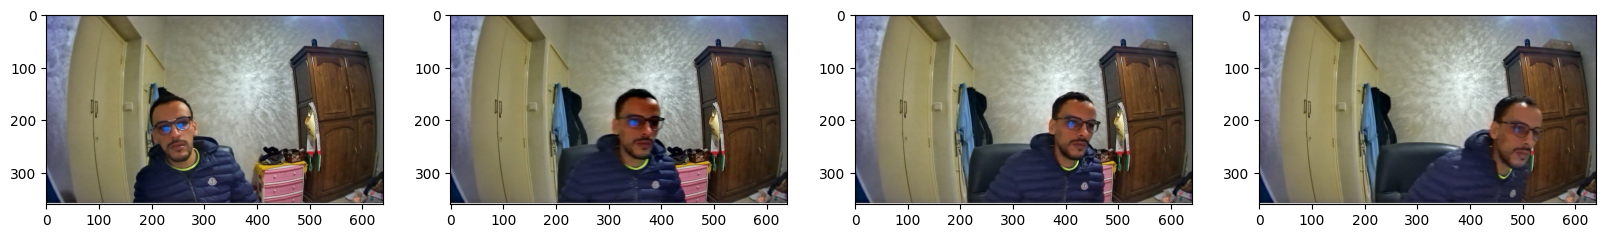

In [17]:
# Visual representation of the plotted images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

## 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLIT DATA INTO TRAIN TEST AND VALIDATION
> In this part we are going to split the data into training, testing, and validation sets and ensure corresponding labels are moved accordingly.
> First we are going to split our 200 collected images manually(without Scikit-learn), we move 140 images randomly from data\\images to data\\train\\images the rest will be 60, then we move 30 from the remaining to data\\test\\images, and 30 to data\\validation\\images.

### 3.2 Move the Matching Labels

In [19]:
# Move the matching labels to their new subdirectory
for folder in ['train','test','validation']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

## 4. Apply Image Augmentation on Images and Labels using Albumentations

>Now we come to the part where we set up Albumentations transform pipeline, then load a test image and annotation, extract and rescale coordinates, and apply augmentations for visual inspection.

### 4.1 Setup Albumentations Transform Pipeline

In [20]:
import albumentations as alb

In [21]:
# Create an Albumentations augmentor with diverse image transformations, optimized for bounding box annotations, encompassing random cropping, flips, brightness/contrast adjustments, gamma correction, and RGB shift.
augmentor = alb.Compose([alb.RandomCrop(width=360, height=360), # we choose (360, 360) to be the crop size because it is smaller than (360, 640) the size of our images
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [27]:
# Loading the test image from "train" folder
img = cv2.imread(os.path.join('data','train', 'images','7c052235-a281-11ee-a2ed-2cf05d228f6b.jpg'))

In [28]:
# image dimensions
img.shape

(360, 640, 3)

In [29]:
# Reading the correspondent annotation of the test image
with open(os.path.join('data', 'train', 'labels', '7c052235-a281-11ee-a2ed-2cf05d228f6b.json'), 'r') as f:
    label = json.load(f)

In [30]:
# Displaying the coordinates of the label
label['shapes'][0]['points']

[[261.90140845070425, 121.19718309859157],
 [380.9154929577465, 284.5774647887324]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [31]:
# Extracting Coordinates
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [32]:
coords

[261.90140845070425, 121.19718309859157, 380.9154929577465, 284.5774647887324]

In [33]:
# Transforming coords from pascal_voc to albumentations format
coords = list(np.divide(coords, [640,360,640,360]))

In [34]:
coords

[0.4092209507042254,
 0.33665884194053214,
 0.5951804577464789,
 0.7904929577464789]

### 4.4 Apply Augmentations and View Results

In [35]:
# Applying transformations, augmenting the input image with specified bounding box coordinates and class labels.
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
augmented['image'].shape

(360, 360, 3)

In [36]:
augmented['bboxes']

[(0.3525039123630674,
  0.20950704225352113,
  0.6830985915492959,
  0.6633411580594679)]

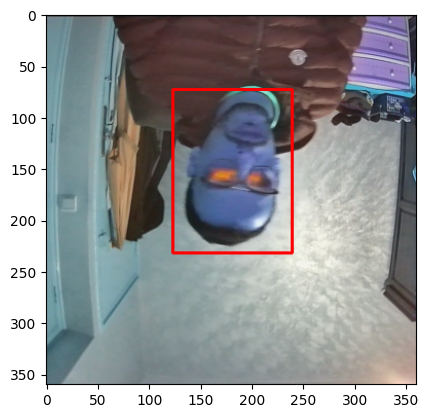

In [37]:
# Draw a rectangle on the augmented image based on the transformed bounding box coordinates
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [350,350]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [350,350]).astype(int)), 
                    (255,0,0), 2)

# Display the augmented image
plt.imshow(augmented['image'])

## 5. Build and Run Augmentation Pipeline

>Now we are going to run the augmentation pipeline on the dataset and loading the resulting augmented images into a TensorFlow dataset for subsequent stages.


### 5.1 Run Augmentation Pipeline

In [38]:
# Iterating through partitions train, test, and validation directories and process images
for partition in ['train','test','validation']: 
   
    # Iterating through images in the current partition
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        
        # Initializing default coordinates
        coords = [0,0,0.00001,0.00001]

        # Checking if corresponding label file exists then read it
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            # Extracting coordinates from the label file and normalize
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,360,640,360]))

        try:
            # Applying augmentation for each image 100 times
            for x in range(100):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                
                # Saving augmented image
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                # Preparing annotation information
                annotation = {'image': image}

                # Checking if label file exists
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 

                # Saving augmented annotation
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
x_max is less than or equal to x_min for bbox [0.246368838028169, 0.0060641627543036, 4.4408920985006264e-17, 0.5887460177733064, 'face'].
x_max is less than or equal to x_min for bbox [0.8350572183098592, 0.7591940532081378, 0.7404269366197184, 0.9763302034428795, 'face'].
x_max is less than or equal to x_min for bbox [0.9263864436619718, 0.6770344287949922, 0.639130407444668, 0.0, 'face'].
y_max is less than or equal to y_min for bbox [0.2716769366197183, 0.21341940532081383, 0.5093529929577465, 0.0021517996870109753, 'face'].
y_max is less than or equal to y_min for bbox [0.0747139084507042, 0.5772691705790297, 0.33015551643192487, -7.894919286223336e-17, 'face'].
y_max is less than or equal to y_min for bbox [0.08351672535211266, 0.6046557120500782, 0.34244590527033164, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.8790713028169014, 0.10191705790297342, 0.7216789372599233, 1.973729821555834e-17, 'face'].
x_max is less than or equal to

### 5.2 Load Augmented Images to Tensorflow Dataset

In [15]:
# Creating a TensorFlow dataset containing file paths of augmented training images
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)

# Mapping the load_image function to decode images and resize them to (120, 120)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))

# Normalizing pixel values to the range [0, 1]
train_images = train_images.map(lambda x: x/255)

In [16]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [17]:
val_images = tf.data.Dataset.list_files('aug_data\\validation\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [42]:
# Retrieving the next element from the augmented training images dataset as a NumPy array
train_images.as_numpy_iterator().next()

array([[[0.99215686, 0.91764706, 0.9019608 ],
        [0.9882353 , 0.9098039 , 0.90588236],
        [0.9843137 , 0.90588236, 0.9019608 ],
        ...,
        [0.99607843, 0.9137255 , 0.9098039 ],
        [0.99215686, 0.9137255 , 0.9098039 ],
        [1.        , 0.91764706, 0.9137255 ]],

       [[0.0627451 , 0.00392157, 0.        ],
        [0.07058824, 0.01176471, 0.        ],
        [0.05882353, 0.00392157, 0.        ],
        ...,
        [0.05882353, 0.00392157, 0.        ],
        [0.05882353, 0.00392157, 0.        ],
        [0.05882353, 0.00392157, 0.        ]],

       [[0.04313726, 0.        , 0.        ],
        [0.03921569, 0.        , 0.        ],
        [0.03921569, 0.        , 0.        ],
        ...,
        [0.02745098, 0.        , 0.        ],
        [0.02745098, 0.        , 0.        ],
        [0.02745098, 0.        , 0.        ]],

       ...,

       [[0.07058824, 0.        , 0.        ],
        [0.07843138, 0.        , 0.00392157],
        [0.08235294, 0

## 6. Prepare Labels

>The next stage is building a label loading function to load and process labels to the TensorFlow dataset.

### 6.1 Build Label Loading Function

In [6]:
# Defining a function to load labels from a specified label file path
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    # Return class label and bounding box coordinates
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [18]:
# Creating a TensorFlow dataset containing file paths of augmented training labels
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)

# Mapping the load_labels function to load and process labels using TensorFlow's py_function
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [19]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [20]:
val_labels = tf.data.Dataset.list_files('aug_data\\validation\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [47]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.505 , 0.1704, 0.8667, 0.6733], dtype=float16))

## 7. Combine Label and Image Samples

>After that we create final datasets for images and labels, and viewing images and annotations to ensure proper alignment.

### 7.1 Check Partition Lengths

In [21]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(13100, 13100, 2800, 2800, 3000, 3000)

### 7.2 Create Final Datasets (Images/Labels)

In [22]:
# Combining augmented training images and labels into a single dataset
train = tf.data.Dataset.zip((train_images, train_labels))

# Shuffling the combined dataset for randomness
train = train.shuffle(15000)

# Creating batches of size 16 for training
train = train.batch(16)

# Prefetching batches to improve data pipeline efficiency
train = train.prefetch(8)

In [23]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(4000)
test = test.batch(16)
test = test.prefetch(8)

In [24]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(4000)
val = val.batch(16)
val = val.prefetch(8)

In [52]:
# Retrieving the next batch of labels from the training dataset in NumPy format
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.472  , 0.2251 , 0.8457 , 0.6675 ],
        [0.1631 , 0.2192 , 0.484  , 0.6494 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.779  , 0.3875 , 1.     , 0.773  ],
        [0.0544 , 0.2722 , 0.2793 , 0.6006 ],
        [0.11597, 0.327  , 0.529  , 0.8413 ],
        [0.732  , 0.2251 , 1.     , 0.626  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.3523 , 0.233  , 0.591  , 0.5635 ],
        [0.3396 , 0.4128 , 0.688  , 0.814  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.3374 , 0.3855 , 0.615  , 0.7476 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.8174 , 0.2408 , 1.     , 0.591  ],
        [0.7925 , 0.6357 , 0.994  , 0.904  ],
        [0.4773 , 0.233  , 0.761  , 0.5947 ]], dtype=float16))

### 7.3 View Images and Annotations

In [53]:
# Allowing iteration over the iterator batches in NumPy format
data_samples = train.as_numpy_iterator()

In [54]:
# Retrieving the next batch of labels from the training dataset in NumPy format
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


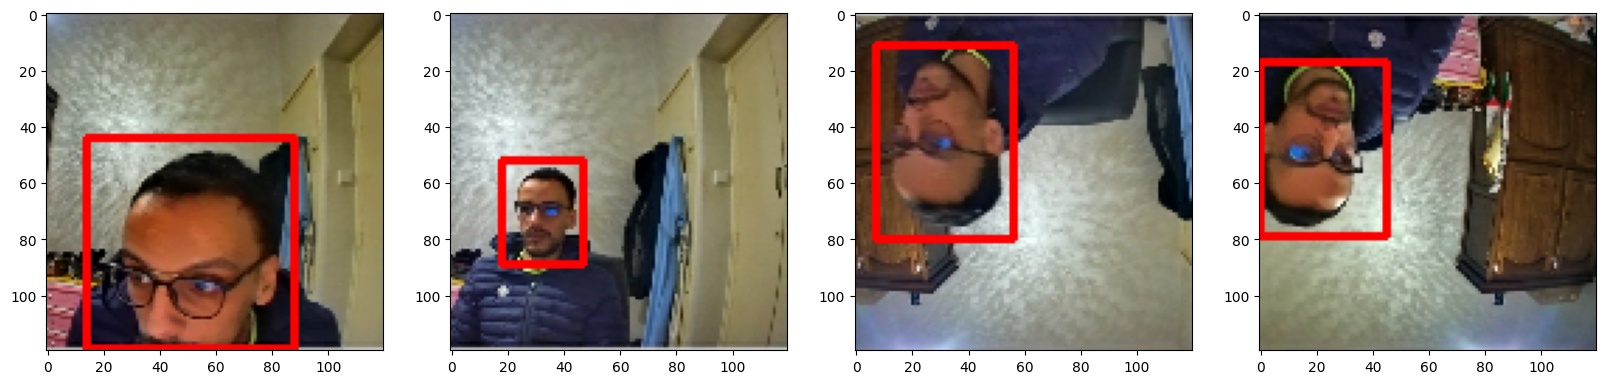

In [55]:
# Create a subplot to visualize a batch of sample images and annotations
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    # Iterate through the first 4 samples in the batch
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    # Draw a rectangle on the sample image based on the sample coordinates
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    # Display the sample image with the rectangle
    ax[idx].imshow(sample_image)

## 8. Build Deep Learning Model using the Functional API

>In this part we begin building our face detection model using the Functional API. It involves importing layers, downloading the <strong>VGG16</strong> architecture, constructing the model, and performing initial tests.<br>
>This stage is pivotal as it establishes the foundation for training a powerful and effective model on the augmented dataset, the adoption of <strong>VGG16</strong> enhances the model's capability and leverages pre-trained weights for improved performance.

### 8.1 Import Layers and Base Network

In [25]:
# Importing necessary modules for building the neural network
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [57]:
# Downloading the VGG16 architecture without the top (fully connected) layers
vgg = VGG16(include_top=False)

In [58]:
# Printing a summary of the VGG16 architecture, providing a detailed overview of its layers, output shapes, and parameters
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [26]:
# Defining a function to build the face detection model using the Functional API
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    # Utilizing the pre-trained VGG16 as the base network
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    # Combining both models into a single face detection model
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [27]:
# Building the face detection model using the defined function
facetracker = build_model()

In [28]:
# Printing a summary of the face detection model architecture
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_1[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [29]:
# Retrieving the next batch of samples from the training dataset
X, y = train.as_numpy_iterator().next()

In [30]:
# Printing the shape of the input data 
X.shape

(16, 120, 120, 3)

In [31]:
# Using the face detection model to predict classes and bounding box coordinates
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [32]:
# Outputing the predicted classes and bounding box coordinates
classes, coords

(array([[0.21565148],
        [0.23739211],
        [0.3101138 ],
        [0.20547582],
        [0.31581834],
        [0.20776448],
        [0.3037406 ],
        [0.30370763],
        [0.21273   ],
        [0.31093362],
        [0.22617753],
        [0.3611334 ],
        [0.28329104],
        [0.2273477 ],
        [0.33630666],
        [0.31278956]], dtype=float32),
 array([[0.44085708, 0.6390264 , 0.38996622, 0.56603694],
        [0.49587265, 0.52985954, 0.3658961 , 0.6466191 ],
        [0.5241916 , 0.48903298, 0.42723694, 0.6086918 ],
        [0.5033412 , 0.58258   , 0.4359164 , 0.56765336],
        [0.51210093, 0.49147654, 0.4556301 , 0.63082266],
        [0.43701038, 0.61694694, 0.37093082, 0.59708697],
        [0.44101822, 0.4679179 , 0.42314857, 0.6424037 ],
        [0.4312641 , 0.58379096, 0.28416336, 0.4781383 ],
        [0.3691623 , 0.51439905, 0.30723208, 0.5754421 ],
        [0.42597005, 0.4458814 , 0.4066859 , 0.6394393 ],
        [0.33245614, 0.6188507 , 0.37865913, 0.6165

## 9. Define Losses and Optimizers

>After building our model, we are going to define the optimizer and learning rate, create localization and classification losses, and test out loss metrics. This step is crucial for optimizing the face detection model and ensuring effective training with accurate loss calculations.

### 9.1 Define Optimizer and Learning Rate

In [33]:
# Calculating the number of batches per epoch
batches_per_epoch = len(train)

# Calculating learning rate decay based on the desired schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=batches_per_epoch,
    decay_rate=0.75,
    staircase=True
)

In [34]:
# Defining the legacy Adam optimizer with specified learning rate and decay
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### 9.2 Create Localization Loss and Classification Loss

In [35]:
# Defining the localization loss function
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [36]:
# Defining binary cross-entropy loss for classification
classloss = tf.keras.losses.BinaryCrossentropy()

# Using the custom localization loss for regression
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [37]:
localization_loss(y[1], coords).numpy()

6.607413

In [38]:
classloss(y[0], classes).numpy()

1.2663021

In [39]:
regressloss(y[1], coords).numpy()

6.607413

## 10. Train Neural Network

> This step involves training the Model to enhance its face detection capabilities, and the custom model class facilitates efficient training and evaluation, while the performance plot provides a quick insight into the learning progress.

### 10.1 Create Custom Model Class

In [40]:
# Defining a custom model class for face tracking
# The FaceTracker class is created as a subclass of the TensorFlow Model class

class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker
   
    # The compile method configures the model with the provided optimizer, classification loss, and localization loss
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    # The train_step method performs a training step, calculating gradients and applying updates to the facetracker model
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    # The test_step method evaluates the model on a test batch and computes relevant loss metrics
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    # Allowing the model to be called with input data
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [41]:
# Creating an instance of the FaceTracker model using the pre-trained facetracker
model = FaceTracker(facetracker)

In [42]:
# Compiling the FaceTracker model with the specified optimizer and loss functions
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [43]:
# Set up TensorBoard callback for logging training progress
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [47]:
# Train the FaceTracker model with TensorBoard callback
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
819/819 [==============================] - 1048s 1s/step - total_loss: 0.0204 - class_loss: 0.0044 - regress_loss: 0.0182 - val_total_loss: 0.0051 - val_class_loss: 2.8694e-04 - val_regress_loss: 0.0050
Epoch 2/20
819/819 [==============================] - 1076s 1s/step - total_loss: 0.0157 - class_loss: 0.0031 - regress_loss: 0.0142 - val_total_loss: 0.0563 - val_class_loss: 7.1768e-05 - val_regress_loss: 0.0562
Epoch 3/20
819/819 [==============================] - 1031s 1s/step - total_loss: 0.0129 - class_loss: 0.0025 - regress_loss: 0.0116 - val_total_loss: 0.0360 - val_class_loss: 0.0064 - val_regress_loss: 0.0328
Epoch 4/20
819/819 [==============================] - 1029s 1s/step - total_loss: 0.0114 - class_loss: 0.0021 - regress_loss: 0.0104 - val_total_loss: 0.0106 - val_class_loss: 9.9093e-07 - val_regress_loss: 0.0106
Epoch 5/20
819/819 [==============================] - 1031s 1s/step - total_loss: 0.0105 - class_loss: 0.0018 - regress_loss: 0.0096 - val_total_los

### 10.3 Plot Performance

In [78]:
# Getting all loss metrics
hist.history

{'total_loss': [0.31038063764572144,
  0.0645294263958931,
  0.28090035915374756,
  0.016818692907691002,
  0.03946767747402191,
  0.009986907243728638,
  0.01003637071698904,
  0.0042227995581924915,
  0.0029145358130335808,
  0.003242931794375181],
 'class_loss': [0.22192184627056122,
  0.038974057883024216,
  0.04272596165537834,
  0.004190432373434305,
  0.013112615793943405,
  0.006994066294282675,
  0.0017334803706035018,
  0.0009200270287692547,
  0.0004291682271286845,
  0.0003881302254740149],
 'regress_loss': [0.19941970705986023,
  0.04504239559173584,
  0.25953736901283264,
  0.014723476022481918,
  0.03291137143969536,
  0.006489874329417944,
  0.009169630706310272,
  0.003762786043807864,
  0.0026999516412615776,
  0.00304886675439775],
 'val_total_loss': [0.05165655165910721,
  0.3802356719970703,
  0.03624599799513817,
  0.013288386166095734,
  0.03230583295226097,
  0.31814607977867126,
  0.04675828665494919,
  0.021005626767873764,
  0.009414141066372395,
  0.46651697

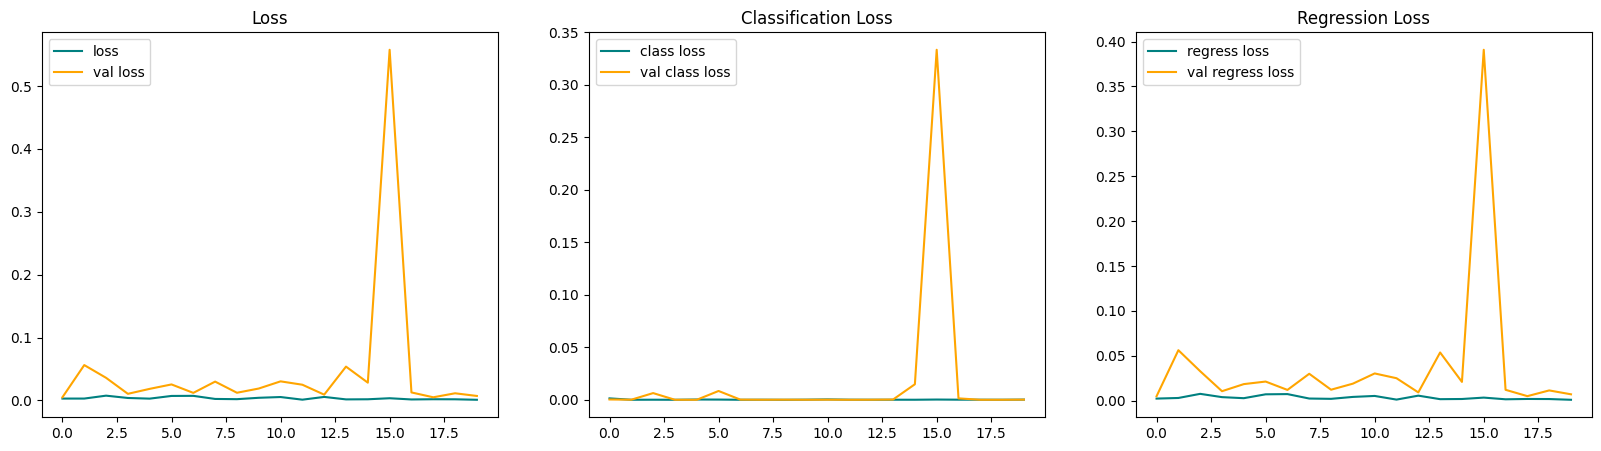

In [48]:
# Create subplots for loss, classification loss, and regression loss
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

# Plot total loss and validation total loss
ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

# Plot classification loss and validation classification loss
ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

# Plot regression loss and validation regression loss
ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## 11. Make Predictions

>Finally, the model is applied to the test set to assess its performance, and then it is saved for future use.<br>
>Additionally, real-time detection is showcased, demonstrating the model's application in live video streams for accurate face detection.

### 11.1 Make Predictions on Test Set

In [80]:
# Get an iterator for the test dataset
test_data = test.as_numpy_iterator()

In [81]:
# Get a sample from the test dataset
test_sample = test_data.next()

In [82]:
# Make predictions using the trained facetracker model on the test sample
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 294ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


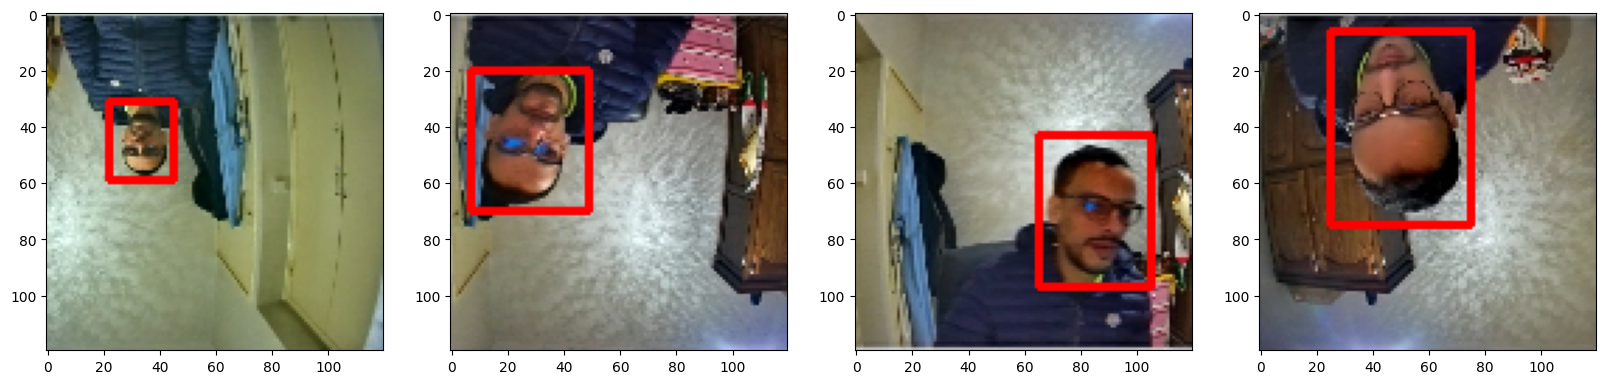

In [83]:
# Visualize the predictions on a sample from the test dataset
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    # Draw a rectangle if the predicted class probability is above 0.9
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                    tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                    tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [50]:
# Import the load_model function from tensorflow.keras.models
from tensorflow.keras.models import load_model

In [52]:
# Save the trained facetracker model to a file
facetracker.save('facetracker.h5')
# facetracker.save('facetracker.keras')

In [89]:
# Load the saved facetracker model from the previous file
facetracker = load_model('facetracker.h5')
# facetracker = load_model('facetracker.keras')

### 11.3 Real Time Detection

In [49]:
# Real-time face detection using the trained facetracker model
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
   
    # Make predictions on the resized frame    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [frame.shape[1], frame.shape[0]]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [frame.shape[1], frame.shape[0]]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [frame.shape[1], frame.shape[0]]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [frame.shape[1], frame.shape[0]]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [frame.shape[1], frame.shape[0]]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 46ms/step


## Conclusion
In summary, this Deep Face DetectionPproject navigated acomplexs process, starting with the capture of 200 facial images through OpenCV and expanding the dataset to 20,000 more with Albumentations. The core involved crafting a face detection system based on the VGG16 architecture using the Functional API. Training strategies were carefully employed for efficiency, demonstrated through real-time face detection. The project's scalability positions it as a flexible solution, adaptable for future enhancements and larger dataset, also it could be use in other scenarios of object detections The main goal was to use the state-of-the-art Computer Vision and Deep Learning techniques to accurate facial recognition.